## 到3. Save File为止应该没什么问题，从第四步开始感觉没什么必要？也没怎么懂。。。（抄的第一个数据集链接里那个人写的）

## 所以只保存了2. Data Prepcoressing部分处理过的数据

# 1. Data installing

In [656]:
import matplotlib.pyplot as plt
import seaborn as sns
            
import seaborn as sns
import matplotlib.pyplot as plt

In [658]:
import pandas as pd
# read file
df = pd.read_csv('loan.csv', index_col=0)
df.shape

C:\Users\onit\AppData\Local\Temp\ipykernel_27952\2672045546.py:3: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('loan.csv', index_col=0)


(887379, 73)

# 2. Data Prepcoressing

### 2.1. Empty & Duplicate Values Analysis

In [661]:
# 删除 application_type 列中值为 'JOINT' 的行(只有511个)，其它都是Individual
df = df[df['application_type'] != 'JOINT']

df.shape

(886868, 73)

In [662]:
# 删除空白太多的列
def del_empty_values(dataframe, lower_bound):
    # 计算每列的缺失值比例
    missing_percentage = dataframe.isnull().mean()

    # 找到空值比例超过 lower_bound 的列
    lower_bound_cols = missing_percentage[missing_percentage > lower_bound].index

    # 删除空值比例超过 lower_bound 的列
    df_cleaned = dataframe.drop(lower_bound_cols, axis=1)

    # 打印删除的列
    print(f"Empty Columns: {list(lower_bound_cols)}\n")
    
    return df_cleaned

df_cleaned = del_empty_values(df, .2)

print(f"Original shape: {df.shape}\nShape after cleaning: {df_cleaned.shape}")

Empty Columns: ['desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']

Original shape: (886868, 73)
Shape after cleaning: (886868, 51)


### 2.2. Delete Useless Columns

In [664]:
# 筛选重复率太高的列
def duplicaate_values(dataframe, upper_bound):
    # 计算每列的缺失值比例
    missing_percentage = dataframe.isnull().mean()

    # 计算每列的重复值比例
    duplicate_percentage = df_cleaned.apply(lambda col: col.value_counts(normalize=True, dropna=False).max())

    # 找到重复比例超过 upper_bound 的列
    upper_bound_cols = duplicate_percentage[duplicate_percentage > upper_bound].index

    # 打印列
    return list(upper_bound_cols)

duplicaate_values = duplicaate_values(df_cleaned, .95)
duplicaate_values

['pymnt_plan',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq']

In [665]:
# 删除不需要的列
def del_useless_columns(dataframe, del_list):
    dataframe.drop(del_list, axis=1, inplace=True, errors='ignore')
    return dataframe

del_list = []
# 筛选出重复太多的列里需要删除的
del_list += ['pymnt_plan', 'policy_code', 'application_type', 'acc_now_delinq']

# 个性化信息，无法分析
del_list += ['member_id', 'url', 'desc', 'title', 'zip_code', 'addr_state', 'initial_list_status', 'emp_title']

# 有_inv后缀的没啥用，后面四个是网站赚的利息，上次付款日期，上次付款金额，网站出账日期，贷款发放日期
del_list += ['funded_amnt_inv', 'out_prncp_inv', 'total_pymnt_inv', 'total_rec_int', 'last_pymnt_d', 'last_pymnt_amnt',	'last_credit_pull_d', 
             'issue_d']

del_useless_columns(df_cleaned, del_list)

print(f"shape after deleting useless columns: {df_cleaned.shape}")

shape after deleting useless columns: (886868, 32)


### 2.3. Missing Values Analysis

In [667]:
# 所有缺失的值大于0的列
null_counts = df_cleaned.isnull().sum()
null_counts = null_counts[null_counts > 0]
print(null_counts)

emp_length                    44764
annual_inc                        4
delinq_2yrs                      29
earliest_cr_line                 29
inq_last_6mths                   29
open_acc                         29
pub_rec                          29
revol_util                      502
total_acc                        29
collections_12_mths_ex_med      145
tot_coll_amt                  70276
tot_cur_bal                   70276
total_rev_hi_lim              70276
dtype: int64


In [668]:
# 删除空缺比例小于6%的行（这样简单一些）
null_percent = (df_cleaned.isnull().sum() / len(df_cleaned)) * 100

# 找出缺失值比例小于 1% 的列
cols_to_drop_rows = null_percent[null_percent < 6].index

# 删除这些列中有缺失值的行
df_cleaned = df_cleaned.dropna(subset=cols_to_drop_rows)

null_counts = df_cleaned.isnull().sum()
null_counts = null_counts[null_counts > 0]
print(null_counts)
print(df_cleaned.shape)

tot_coll_amt        67986
tot_cur_bal         67986
total_rev_hi_lim    67986
dtype: int64
(841504, 32)


In [669]:
# 用 0 填充: tot_coll_amt (曾经欠下的总催收金额)
list_0 = ['tot_coll_amt']

def fill_with_0(list_0):
    for i in list_0:
        df_cleaned[i] = df_cleaned[i].fillna(0)

fill_with_0(list_0)
df_cleaned.shape

(841504, 32)

In [670]:
# 用众数填充: tot_cur_bal (所有账户的当前总余额); total_rev_hi_lim(总循环最高信用/信用限额)
list_mode = ['tot_cur_bal', 'total_rev_hi_lim']

def fill_with_0(list_mode):
    for i in list_mode:
        df_cleaned[i] = df_cleaned[i].fillna(df_cleaned[i].mode()[0])

fill_with_0(list_mode)
df_cleaned.shape

(841504, 32)

In [671]:
# 检查缺失是不是都填充了
null_counts = df_cleaned.isnull().sum()
null_counts = null_counts[null_counts > 0]
print(null_counts)

Series([], dtype: int64)


### 2.4. Convert Datatype

In [673]:
# 转换日期列为 datetime 类型
df_cleaned['earliest_cr_line'] = pd.to_datetime(df_cleaned['earliest_cr_line'], format='%b-%Y')

In [674]:
# term（分期付款的次数）: ['36 months', '60 months'] 变成 int
df_cleaned['term'] = df_cleaned['term'].astype(str)
df_cleaned['term'] = df_cleaned['term'].str.extract(r'(\d+)').astype(int)

In [675]:
# emp_length（工作年限）： 变成 0-10 的整数，10代表大于10年
df_cleaned['emp_length'] = df_cleaned['emp_length'].replace({'< 1 year': '0', '10+ years': '10'})

df_cleaned['emp_length'] = df_cleaned['emp_length'].str.extract(r'(\d+)').astype(int)

In [676]:
# 保存清洗后的数据集
df_cleaned.to_csv('cleaned_data.csv', index=False)

# 3. Save File

In [678]:
df_cleaned.to_csv('cleaned_data.csv', index=False)

# 4. Further Process

### 4.1. Outliers Analysis

In [681]:
# Number of Numerical Variable
num_cols = [col for col in df_cleaned.columns if df[col].dtypes != 'O' and col not in "Id"]
print('Number of Numerical Variable: ', len(num_cols))

Number of Numerical Variable:  23


In [682]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def has_outliers(dataframe, num_col_names, plot=False):
    variable_names = []
    
    for col in num_col_names:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)]
            
        if not outliers.empty:
            number_of_outliers = outliers.shape[0]
            print(col, ":", number_of_outliers)
            variable_names.append(col)

    return variable_names

has_outliers(df_cleaned, num_cols)

int_rate : 6011
installment : 21824
annual_inc : 41396
delinq_2yrs : 162846
inq_last_6mths : 51283
open_acc : 26626
pub_rec : 124439
revol_bal : 46054
revol_util : 49
total_acc : 17486
out_prncp : 1771
total_pymnt : 43282
total_rec_prncp : 55748
total_rec_late_fee : 11982
recoveries : 23537
collection_recovery_fee : 22434
collections_12_mths_ex_med : 11059
tot_coll_amt : 109571
tot_cur_bal : 30094
total_rev_hi_lim : 54217


['int_rate',
 'installment',
 'annual_inc',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'total_pymnt',
 'total_rec_prncp',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim']

In [683]:
# Now, set thresholds(low and up limits) for outliers then use for outliers
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
    replace_with_thresholds(df_cleaned, col)

has_outliers(df_cleaned, num_cols)

[]

### 3.2. Label Encoding & One-Hot Encoding

In [685]:
# 提取所有 object 类型列的列名
object_columns = df_cleaned.select_dtypes(include=['object']).columns.tolist()
object_columns

['grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'loan_status',
 'purpose']

In [686]:
# 为列创建独热编码
def one_hot_encoding(dataframe, object_columns):
    for object_column in object_columns:
        dataframe = dataframe.merge(pd.get_dummies(dataframe[object_column], drop_first=True, prefix=object_column), left_index=True, right_index=True)
        dataframe.drop(object_column, axis= 1, inplace = True)
    return dataframe

df_cleaned = one_hot_encoding(df_cleaned, object_columns)

In [687]:
df_cleaned.head()

,loan_amnt,funded_amnt,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,earliest_cr_line,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
id,,,,,,,,,,,,,,,,,,,,,
1077501,5000.0,5000.0,36,10.65,162.87,10,24000.0,27.65,0.0,1985-01-01,...,False,False,False,False,False,False,False,False,False,False
1077430,2500.0,2500.0,60,15.27,59.83,0,30000.0,1.00,0.0,1999-04-01,...,False,False,False,False,False,False,False,False,False,False
1077175,2400.0,2400.0,36,15.96,84.33,10,12252.0,8.72,0.0,2001-11-01,...,False,False,False,False,False,False,False,True,False,False
1076863,10000.0,10000.0,36,13.49,339.31,10,49200.0,20.00,0.0,1996-02-01,...,False,False,False,False,False,True,False,False,False,False
1075358,3000.0,3000.0,60,12.69,67.79,1,80000.0,17.94,0.0,1996-01-01,...,False,False,False,False,False,True,False,False,False,False


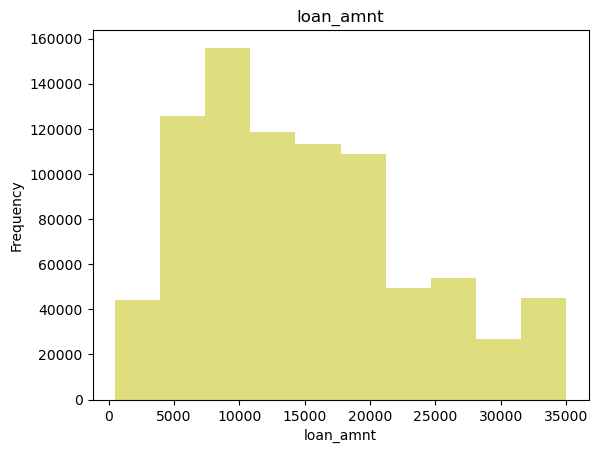

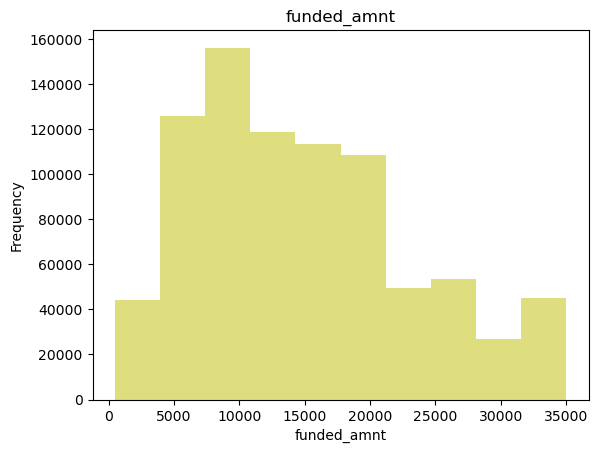

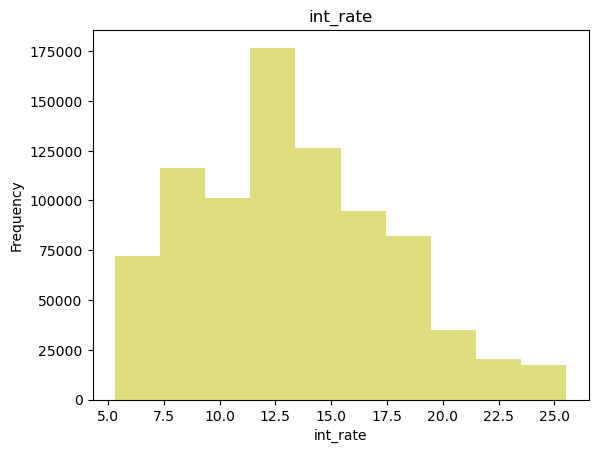

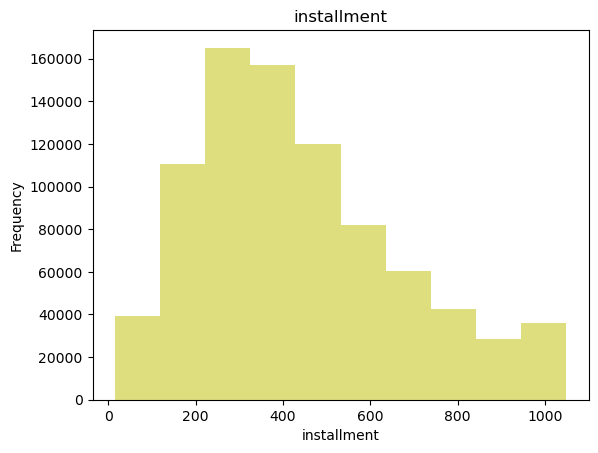

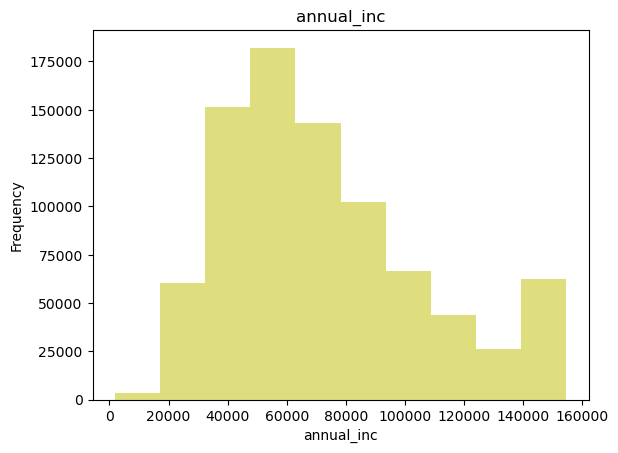

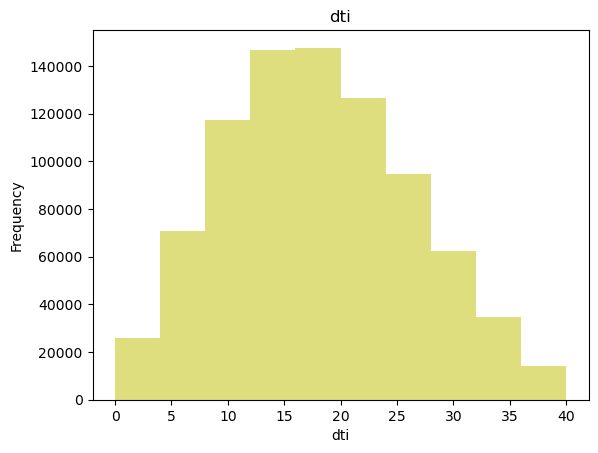

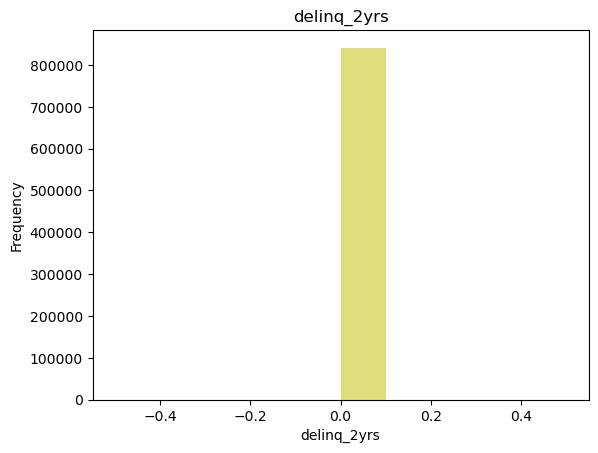

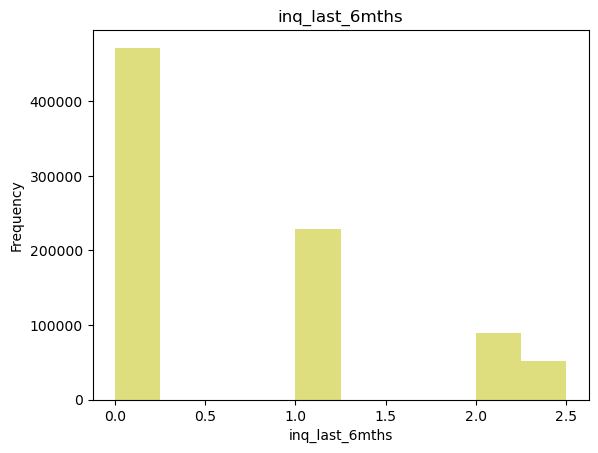

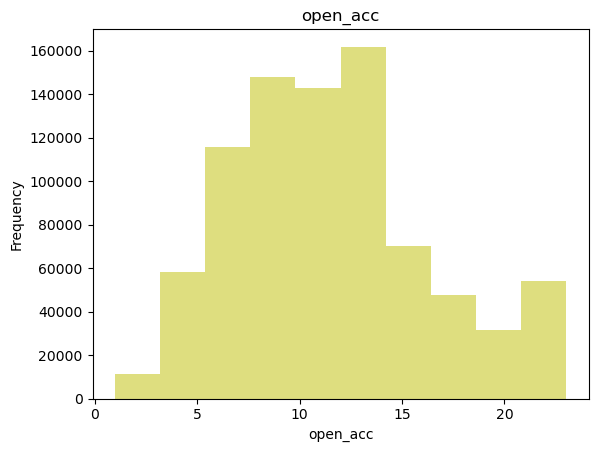

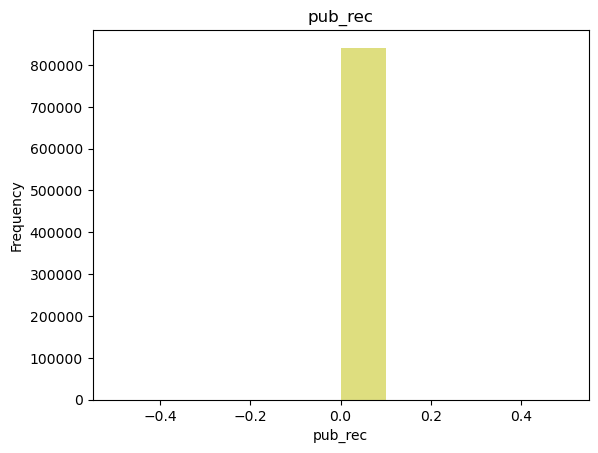

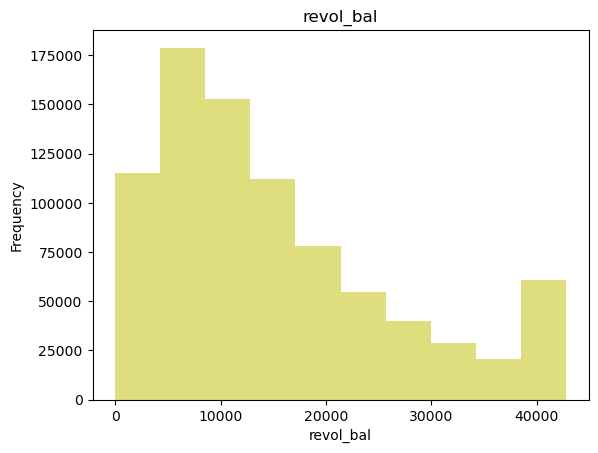

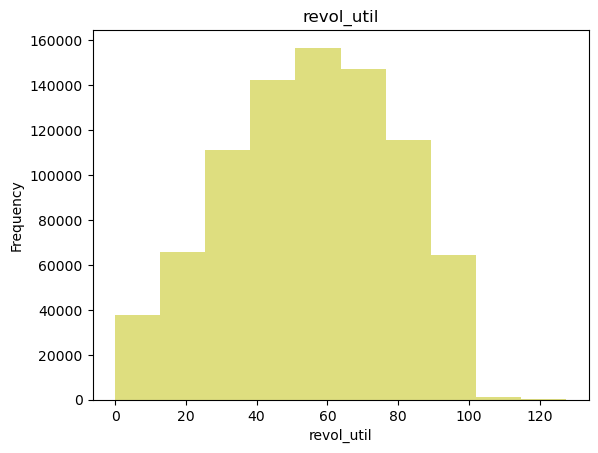

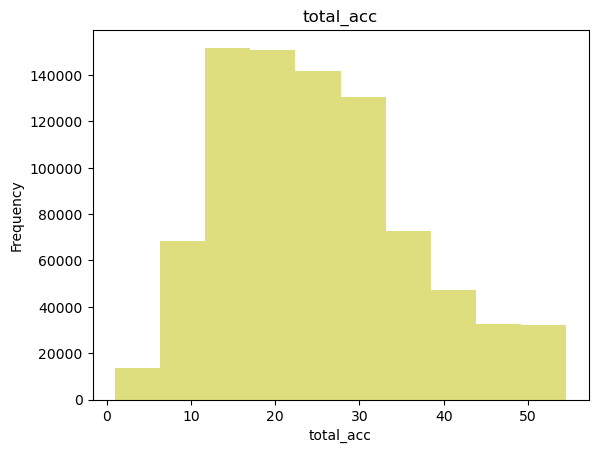

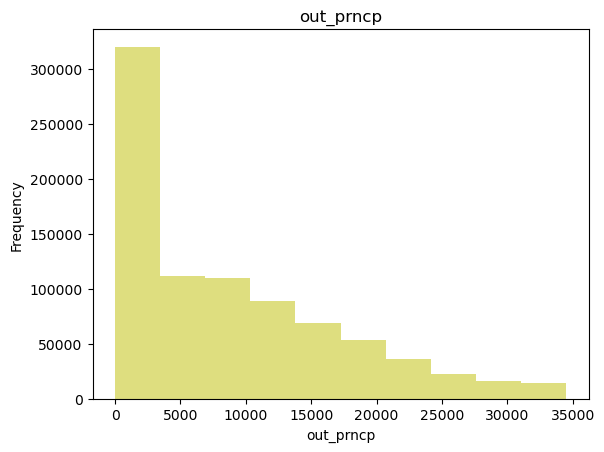

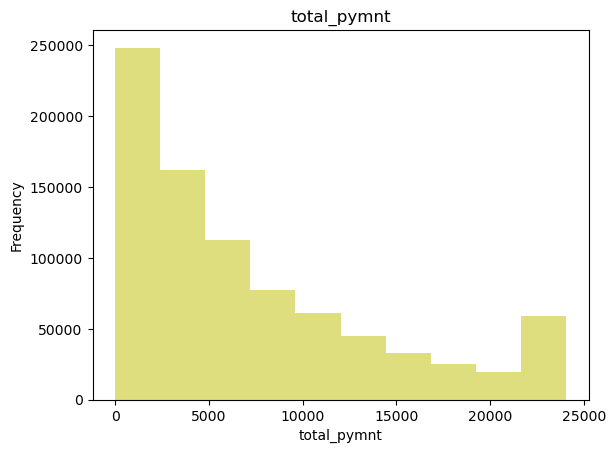

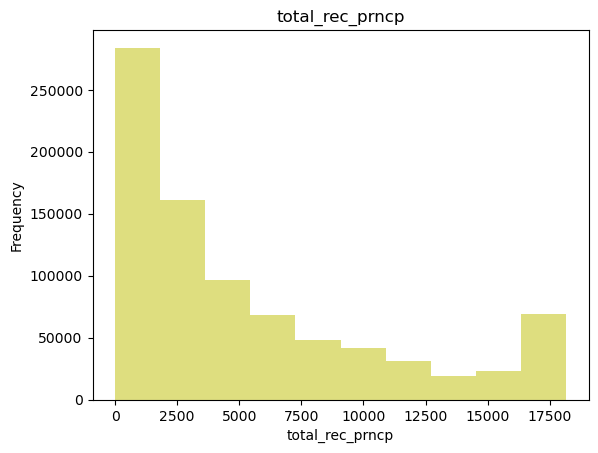

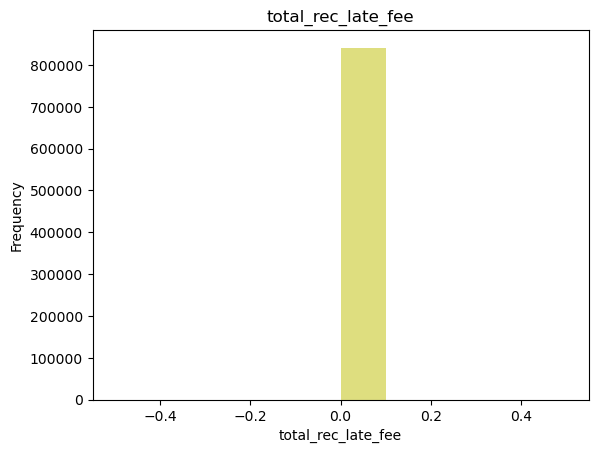

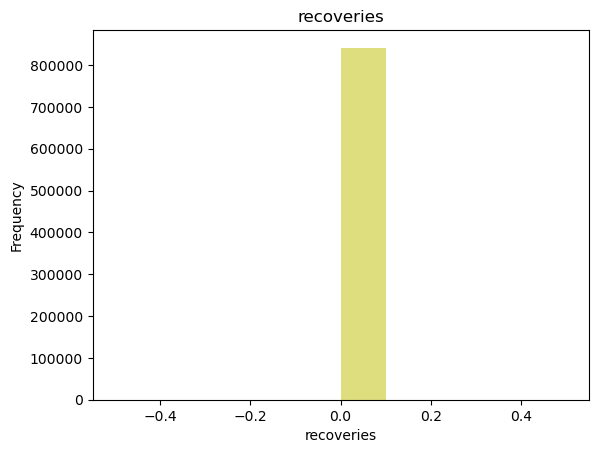

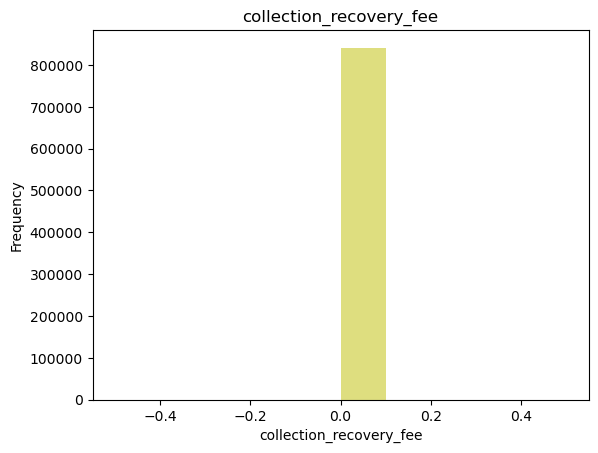

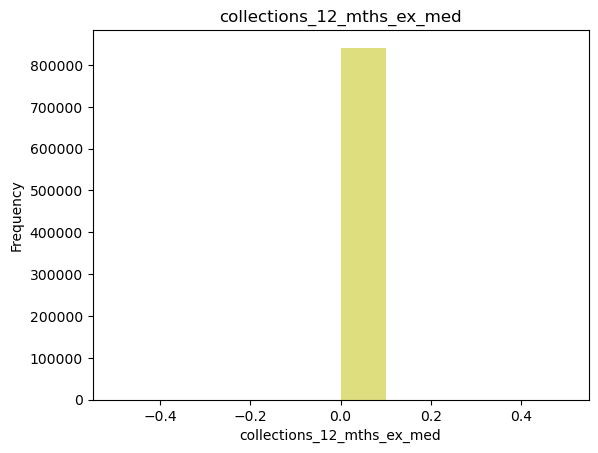

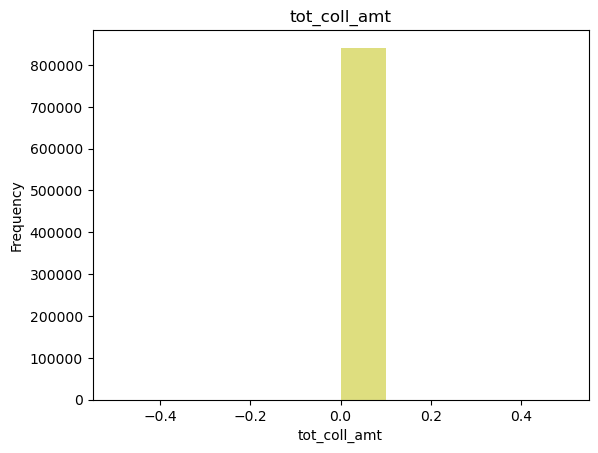

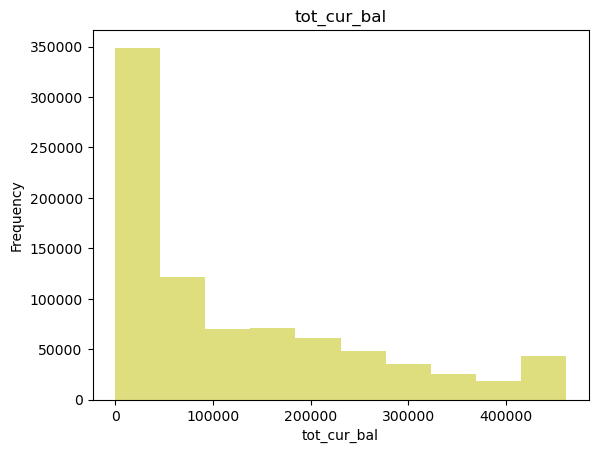

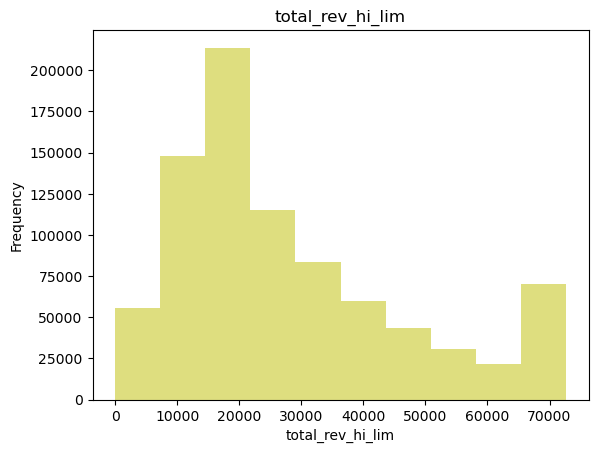

23 variables have been plotted


In [718]:
def hist_for_nums(data, numeric_cols):
    col_counter = 0
    data = data.copy()
    for col in numeric_cols:
        data[col].plot.hist(alpha=0.5, color='y')
        plt.xlabel(col)
        plt.title(col)
        plt.show()
        col_counter += 1
    print(col_counter, "variables have been plotted")


hist_for_nums(df_cleaned, num_cols)

### 3.3. Standardization

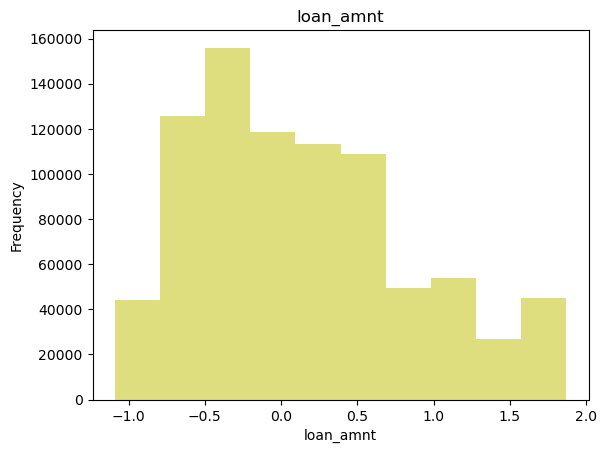

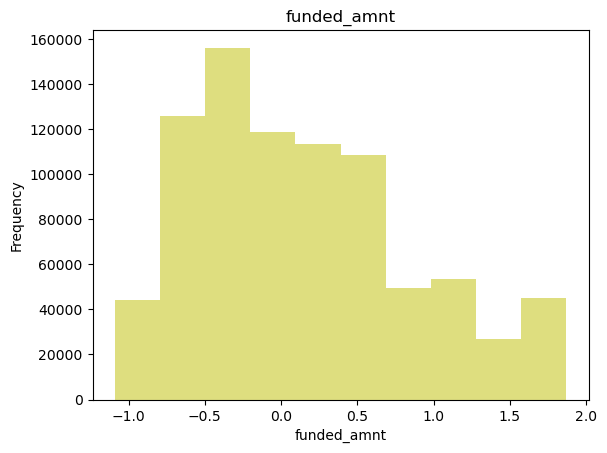

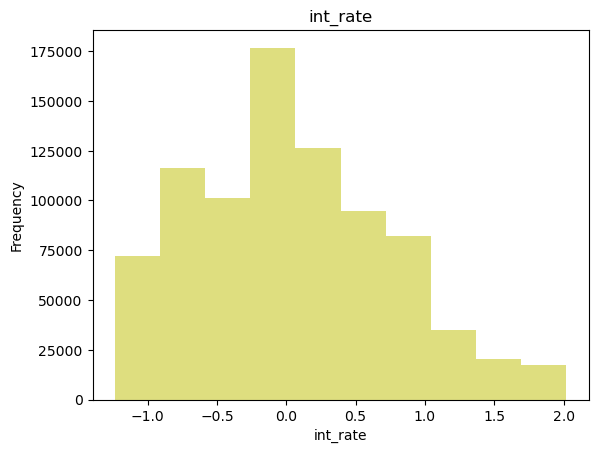

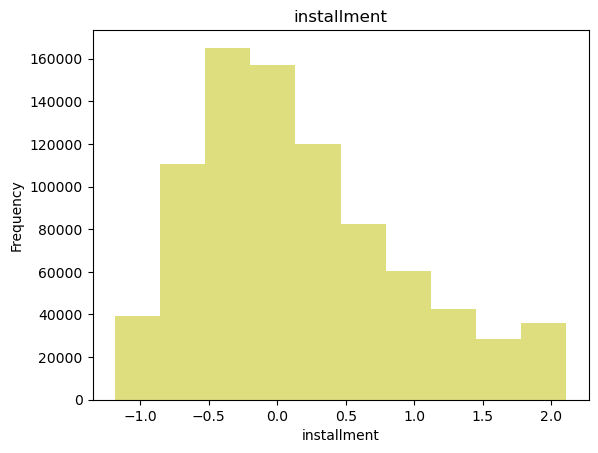

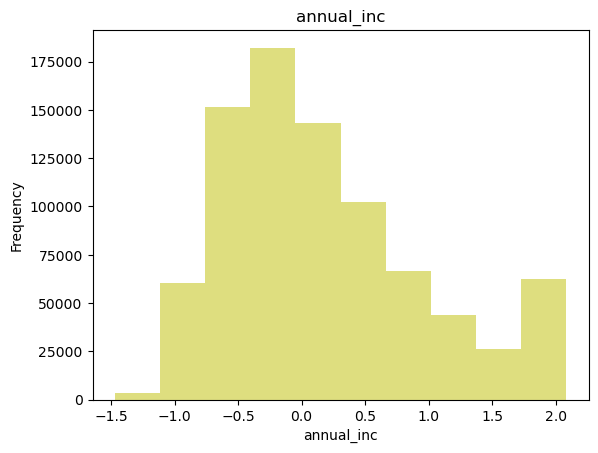

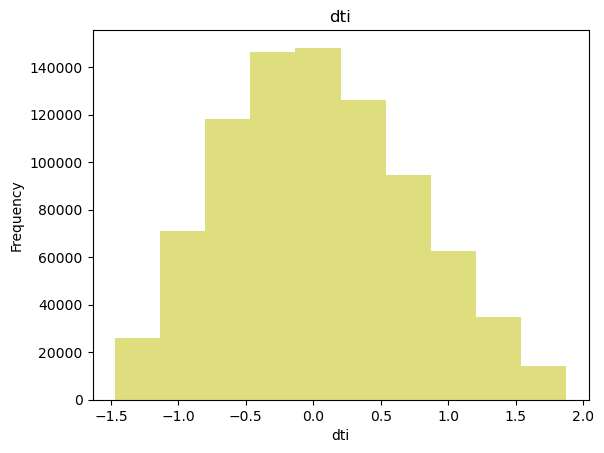

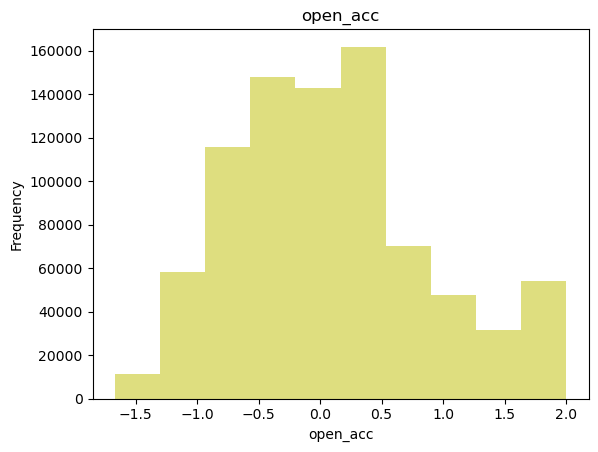

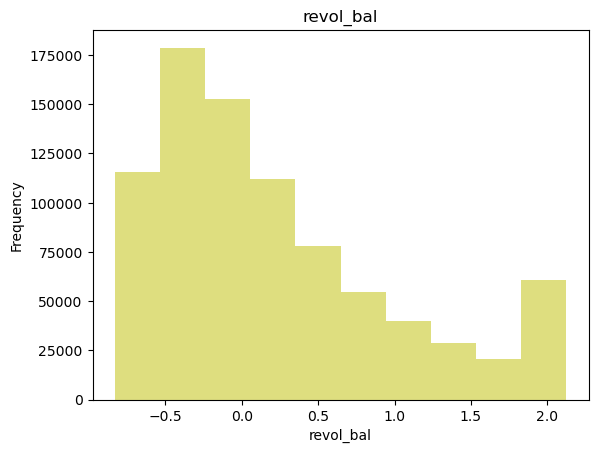

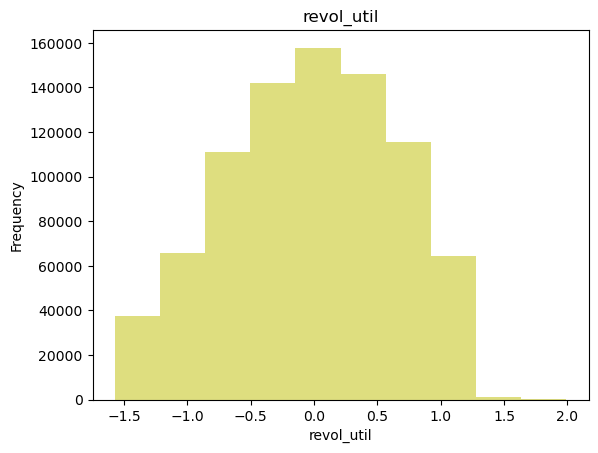

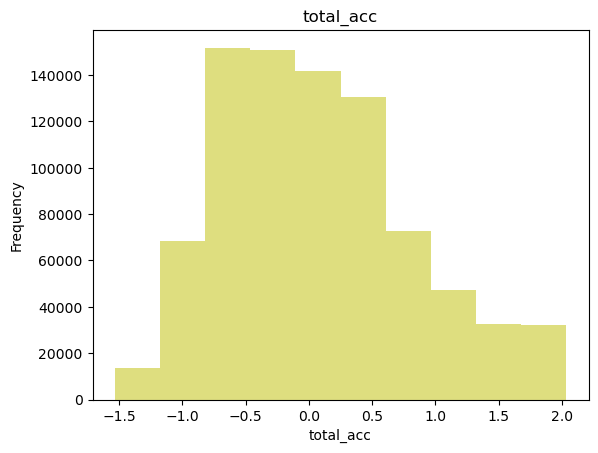

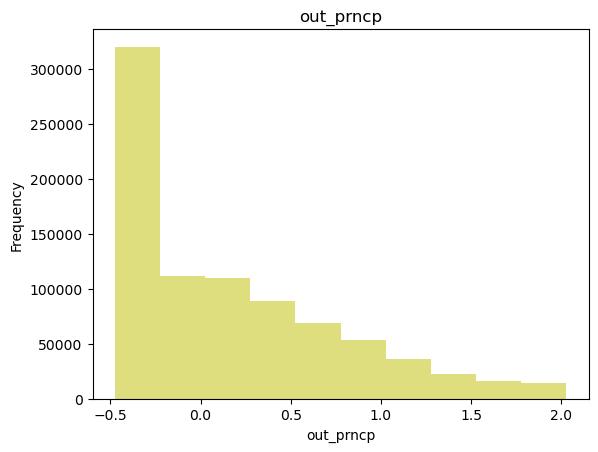

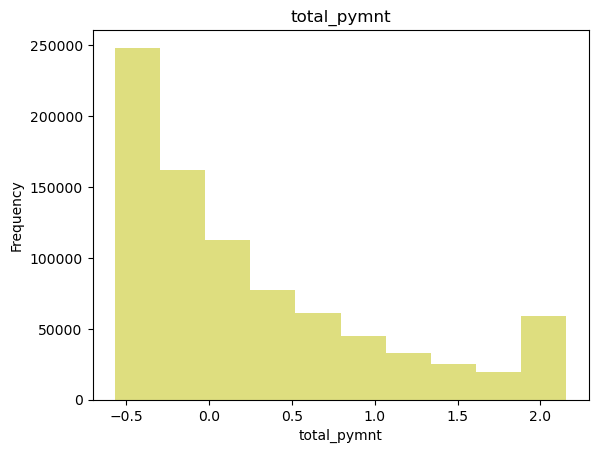

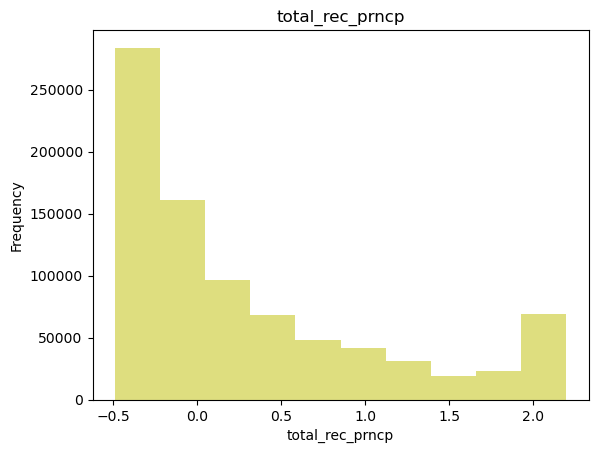

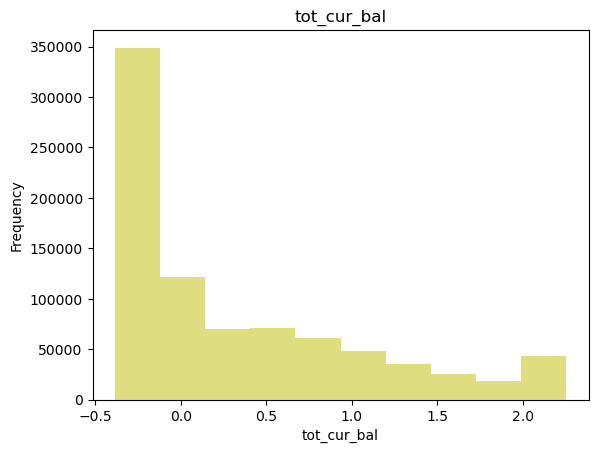

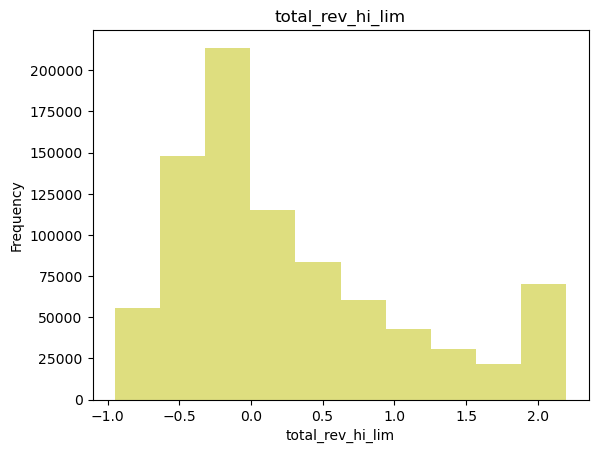

15 variables have been plotted


In [730]:
numeric_cols = df_cleaned.select_dtypes(include=['number']).columns.tolist()


cols_need_scale = [col for col in numeric_cols if col not in "Id"
                   and col not in ['grade', 'sub_grade']
                   and col not in like_num]

def robust_scaler(variable):
    var_median = variable.median()
    quartile1 = variable.quantile(0.25)
    quartile3 = variable.quantile(0.75)
    interquantile_range = quartile3 - quartile1
    if int(interquantile_range) == 0:
        quartile1 = variable.quantile(0.05)
        quartile3 = variable.quantile(0.95)
        interquantile_range = quartile3 - quartile1
        z = (variable - var_median) / interquantile_range
        return round(z, 3)
    else:
        z = (variable - var_median) / interquantile_range
    return round(z, 3)

for col in cols_need_scale:
    df_cleaned[col] = robust_scaler(df_cleaned[col])

df_cleaned[cols_need_scale].head()
df_cleaned[cols_need_scale].describe().T
hist_for_nums(df_cleaned, cols_need_scale)

### 3.4. Correlation and Heatmap Analysis

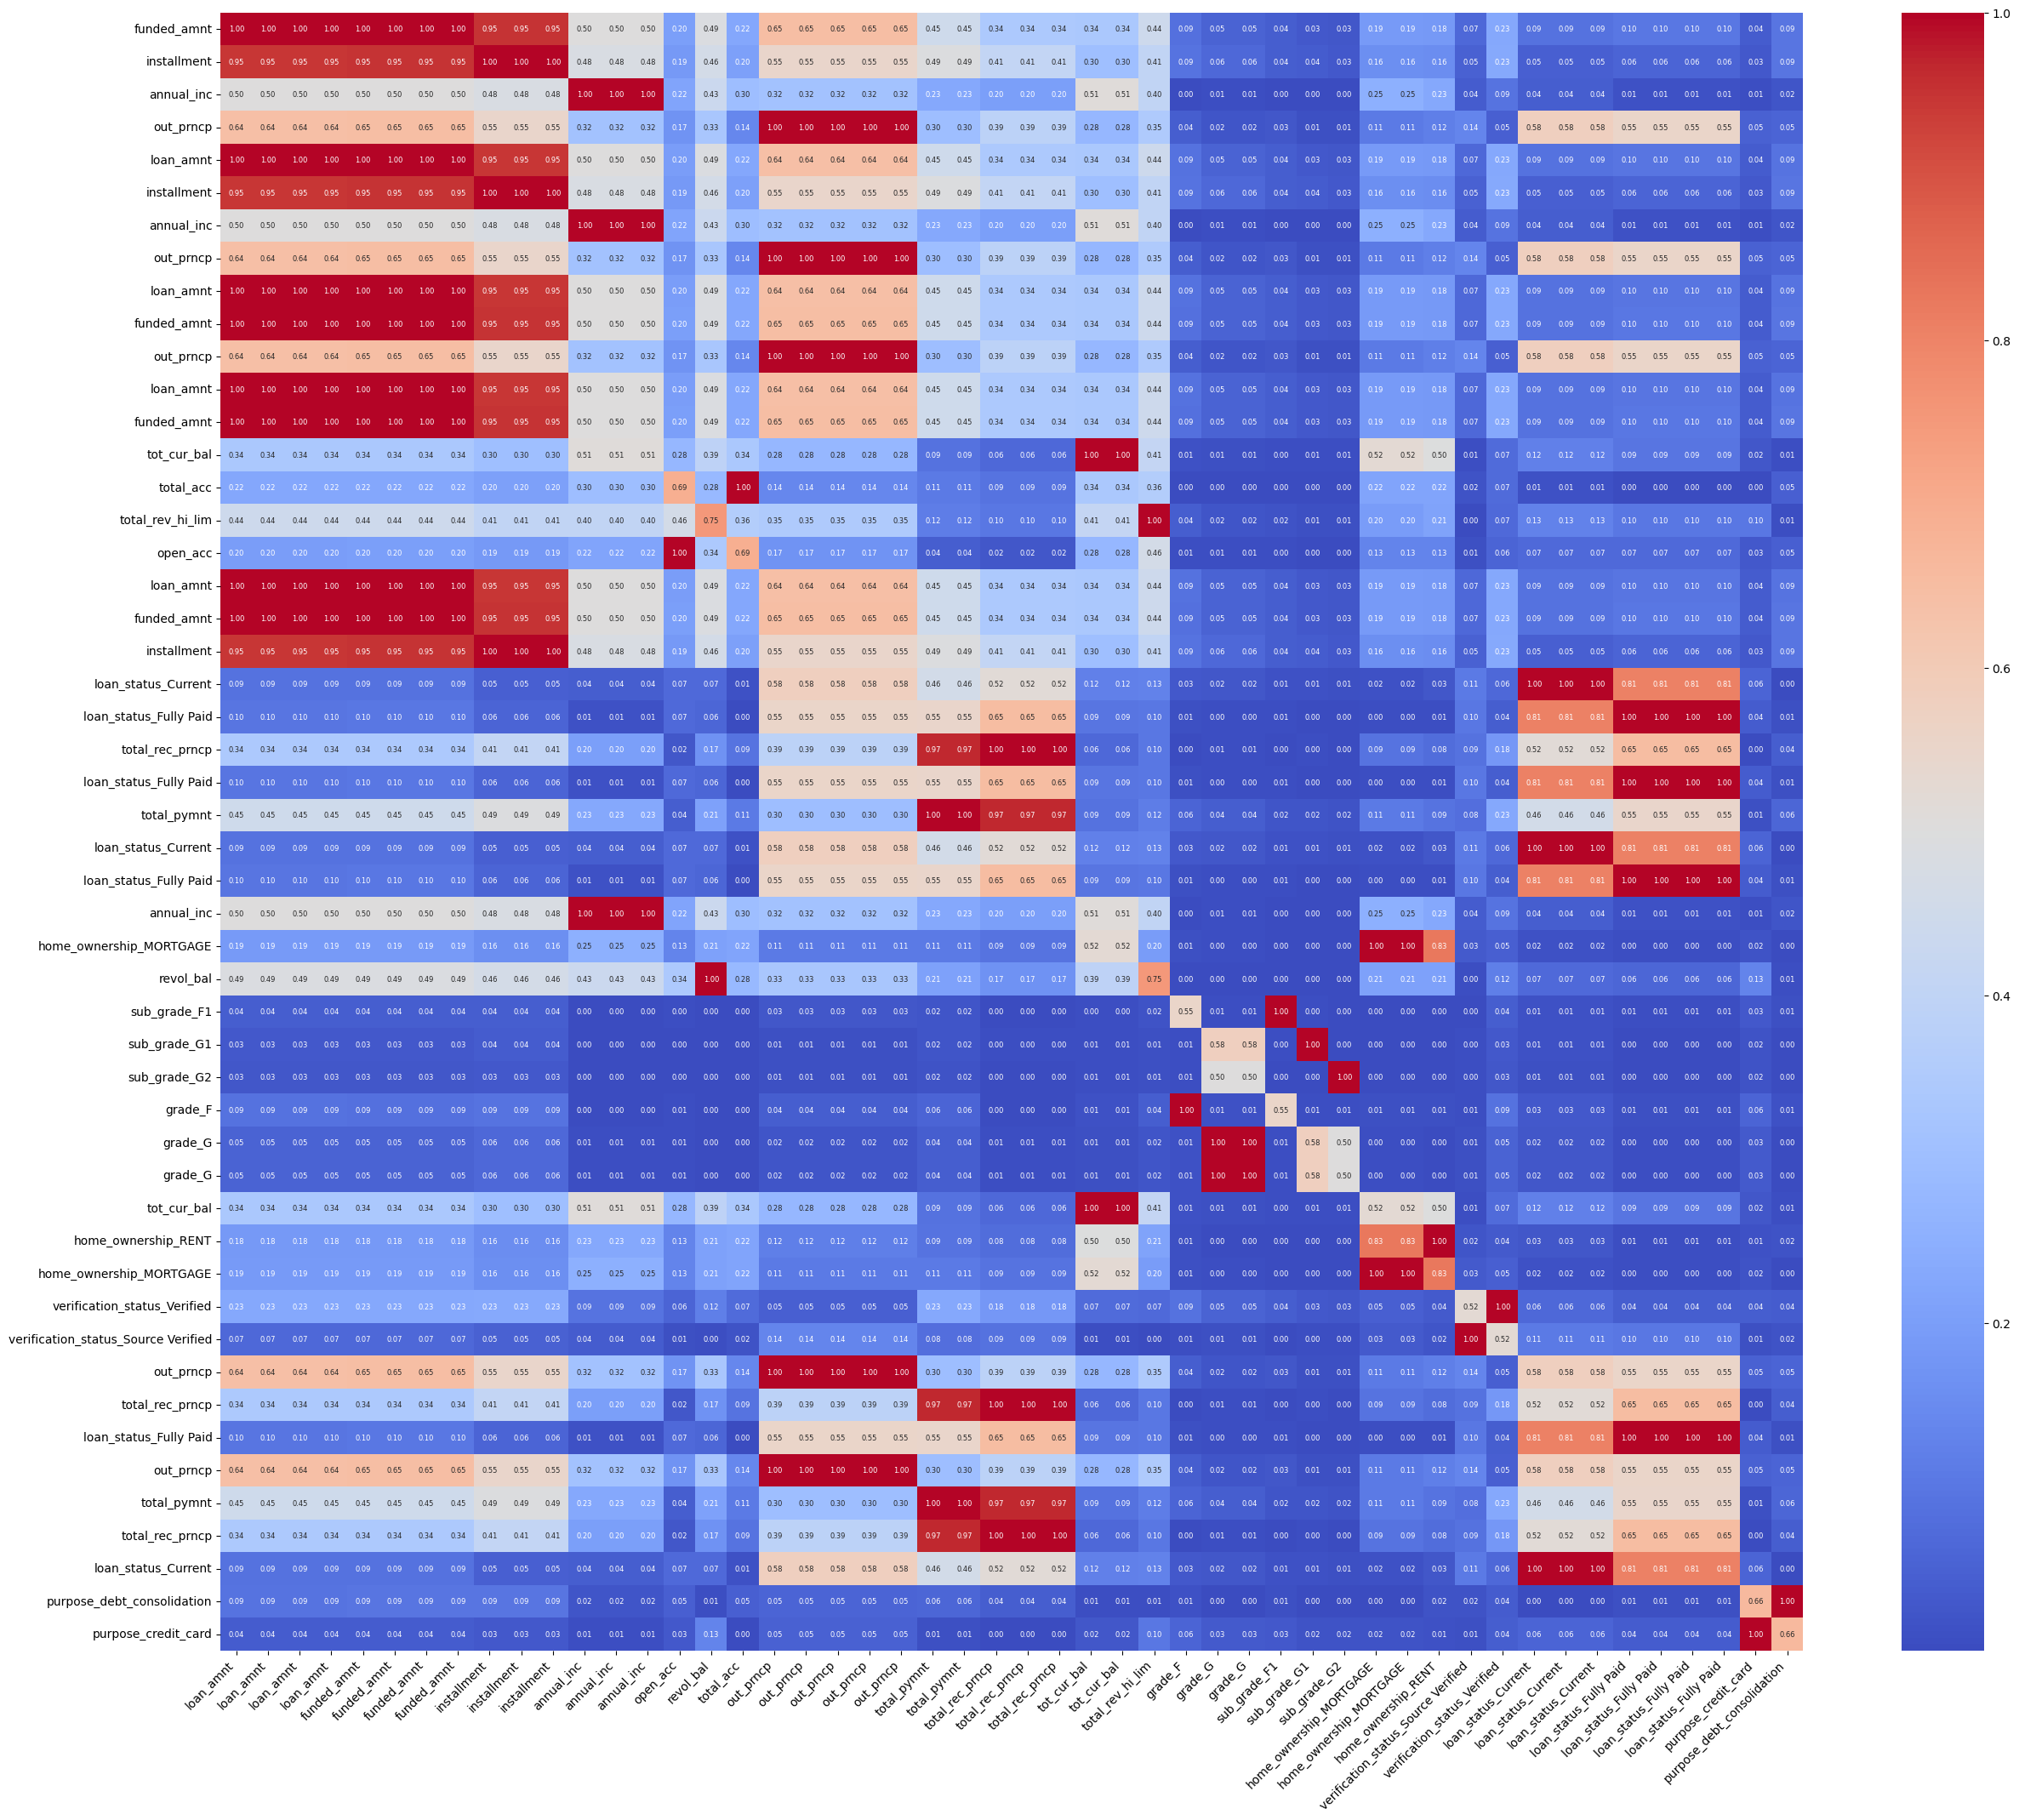

In [739]:
corr_matrix = df_cleaned.corr().abs()  # 取相关系数的绝对值
high_corr_vars = corr_matrix[corr_matrix > 0.5].stack().reset_index()
high_corr_vars = high_corr_vars[high_corr_vars['level_0'] != high_corr_vars['level_1']]  # 去除自相关

# 根据筛选的特征生成热力图
plt.figure(figsize=(30,25))
sns.heatmap(corr_matrix[high_corr_vars['level_0']].loc[high_corr_vars['level_1']],
            cmap='coolwarm',
            annot=True,
            fmt=".2f",
            annot_kws={'size':6},
            cbar=True)
plt.xticks(rotation=45, ha='right', size=10)
plt.yticks(size=10)
plt.show()


# 4. Save File

In [741]:
df_cleaned.to_csv('cleaned_data_2.csv', index=False)